In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
import joblib
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Set visualization style
sns.set_style('whitegrid')

In [25]:
# Set up paths
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent
DATA_PATH = ROOT_DIR / "data" / "processed" / "merged_customer_data.csv"

# Create results and visualizations directories
results_dir = NOTEBOOK_DIR / "product_recommendation_results"
results_dir.mkdir(exist_ok=True)
visualizations_dir = results_dir / "Visualizations"
visualizations_dir.mkdir(exist_ok=True)

# Load the dataset
df = pd.read_csv(DATA_PATH)

print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst 10 rows:")
display(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print(f"\nDuplicate Rows: {df.duplicated().sum()}")


Shape: 213 rows × 10 columns

First 10 rows:


,customer_id,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,151,1001,408,2024-01-01,Sports,2.3,TikTok,61,1.3,Neutral
1,151,1001,408,2024-01-01,Sports,2.3,Twitter,72,1.6,Neutral
2,151,1001,408,2024-01-01,Sports,2.3,Twitter,82,3.6,Negative
3,192,1002,332,2024-01-02,Electronics,4.2,Instagram,60,4.3,Positive
4,114,1003,442,2024-01-03,Electronics,2.1,Facebook,87,4.8,Negative
5,160,1005,64,2024-01-05,Clothing,1.3,TikTok,56,2.6,Positive
6,160,1005,64,2024-01-05,Clothing,1.3,LinkedIn,73,2.0,Neutral
7,160,1005,64,2024-01-05,Clothing,1.3,Instagram,89,2.9,Neutral
8,120,1006,395,2024-01-06,Groceries,1.1,Facebook,83,1.4,Positive
9,120,1006,395,2024-01-06,Groceries,1.1,Instagram,56,3.0,Positive



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              213 non-null    int64  
 1   transaction_id           213 non-null    int64  
 2   purchase_amount          213 non-null    int64  
 3   purchase_date            213 non-null    object 
 4   product_category         213 non-null    object 
 5   customer_rating          213 non-null    float64
 6   social_media_platform    213 non-null    object 
 7   engagement_score         213 non-null    int64  
 8   purchase_interest_score  213 non-null    float64
 9   review_sentiment         213 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 16.8+ KB
None

Missing Values:
customer_id                0
transaction_id             0
purchase_amount            0
purchase_date              0
product_category           0
cu

## Exploratory Data Analysis

In [26]:

print("\nDistribution:")
print(df['product_category'].value_counts())
print("\nPercentages:")
print(df['product_category'].value_counts(normalize=True).round(4) * 100)

print("\n NUMERICAL FEATURES SUMMARY:")
print(df.describe())

print("\n CATEGORICAL FEATURES:")
print(f"\nSocial Media Platforms: {df['social_media_platform'].nunique()}")
print(df['social_media_platform'].value_counts())
print(f"\nReview Sentiments: {df['review_sentiment'].nunique()}")
print(df['review_sentiment'].value_counts())


Distribution:
product_category
Sports         59
Electronics    45
Groceries      38
Books          38
Clothing       33
Name: count, dtype: int64

Percentages:
product_category
Sports         27.70
Electronics    21.13
Groceries      17.84
Books          17.84
Clothing       15.49
Name: proportion, dtype: float64

 NUMERICAL FEATURES SUMMARY:
       customer_id  transaction_id  purchase_amount  customer_rating  \
count   213.000000      213.000000       213.000000       213.000000   
mean    147.676056     1075.835681       289.807512         3.070634   
std      32.325632       45.104138       119.323903         1.209302   
min     100.000000     1001.000000        62.000000         1.000000   
25%     117.000000     1040.000000       179.000000         2.100000   
50%     147.000000     1074.000000       282.000000         3.200000   
75%     181.000000     1115.000000       398.000000         4.100000   
max     199.000000     1150.000000       495.000000         5.000000   

    

## EDA Visualizations

EDA visualizations saved as 'c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook\product_recommendation_results\Visualizations\EDA_Product_Model.png'


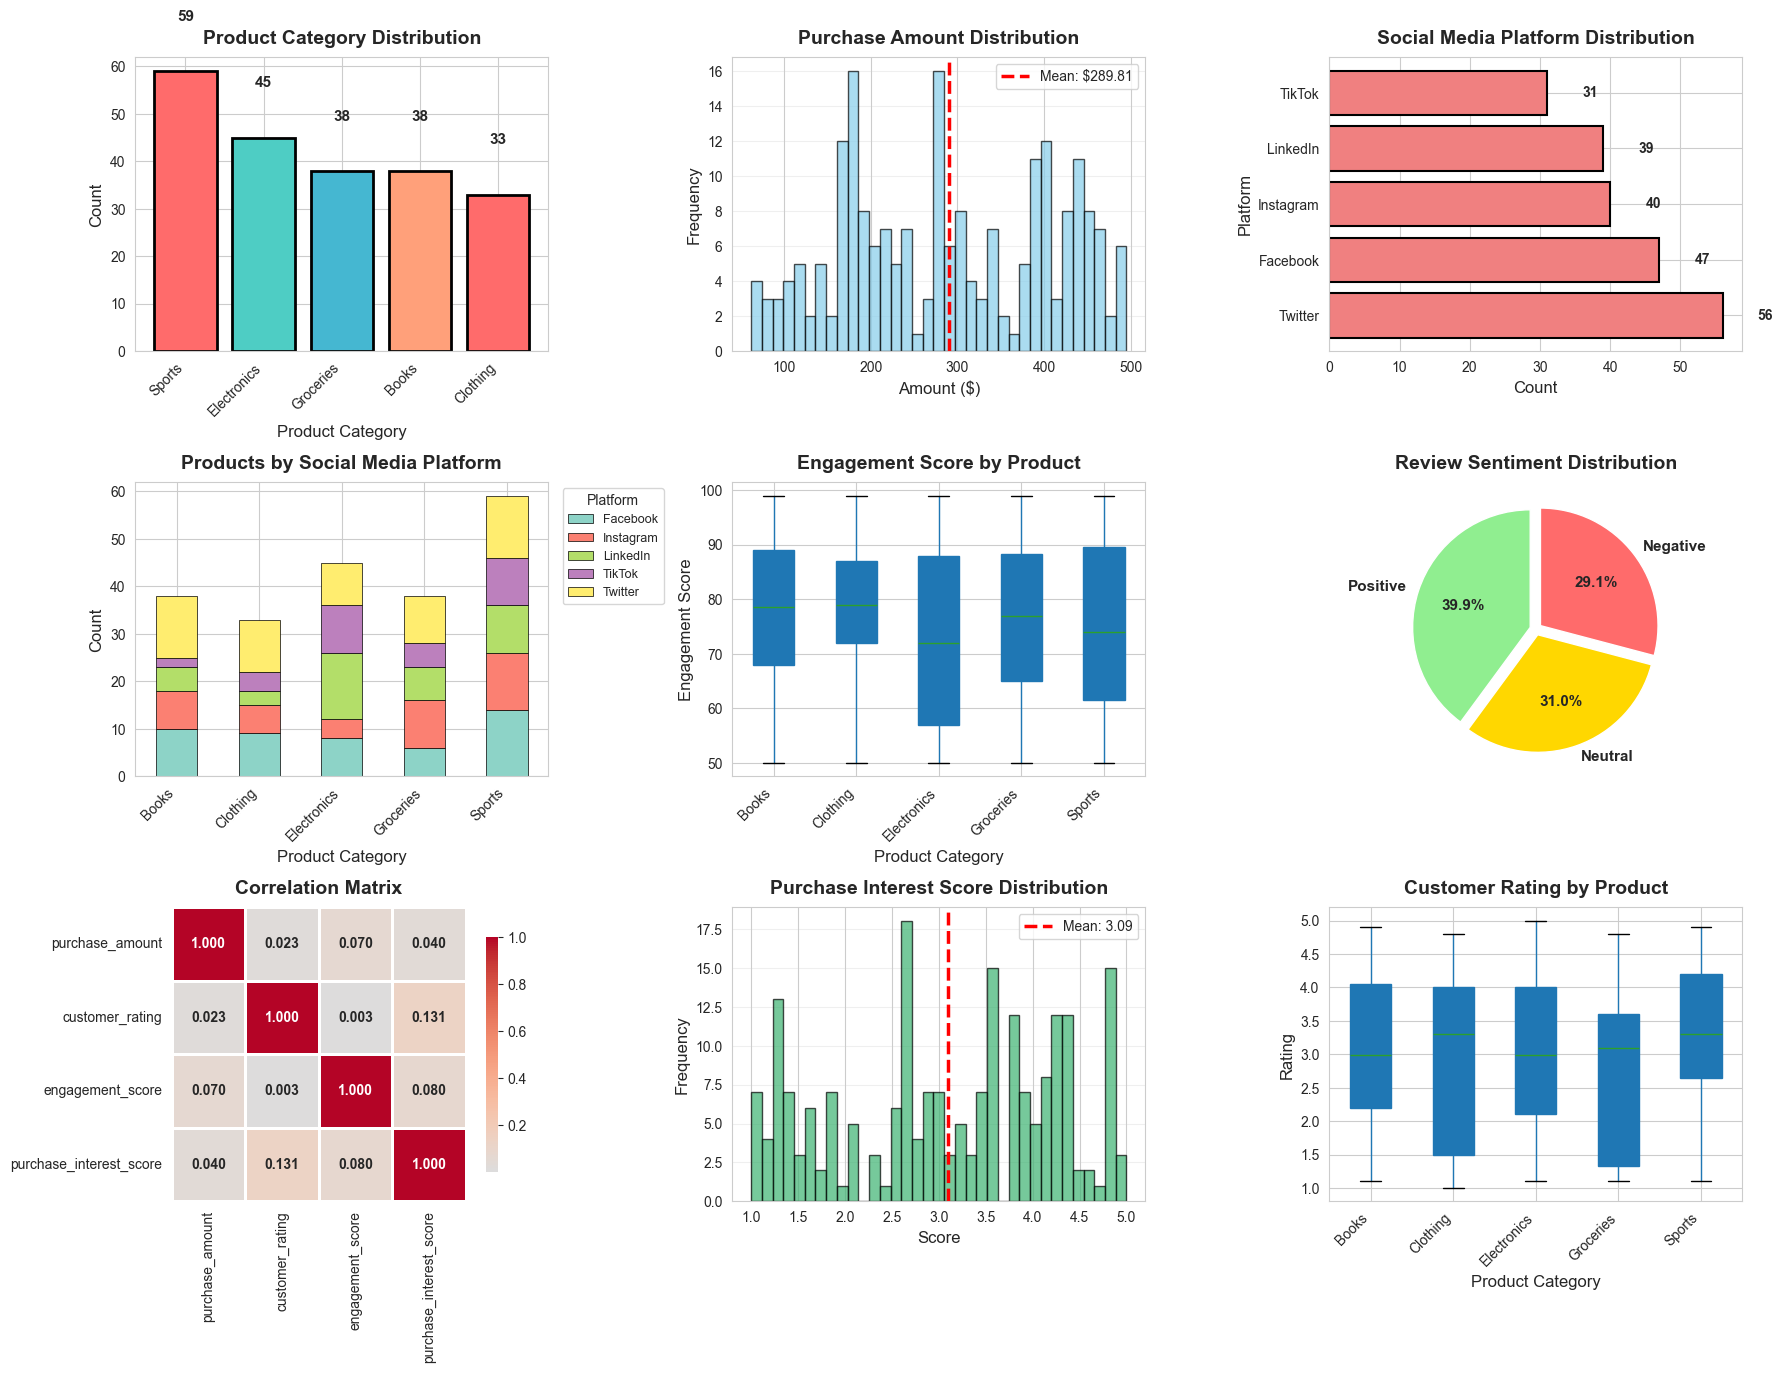

In [27]:
fig = plt.figure(figsize=(18, 14))

plt.subplot(3, 3, 1)
product_counts = df['product_category'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = plt.bar(product_counts.index, product_counts.values, color=colors, edgecolor='black', linewidth=2)
plt.title('Product Category Distribution', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, (bar, v) in enumerate(zip(bars, product_counts.values)):
    plt.text(bar.get_x() + bar.get_width()/2, v + 10, str(v),
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.subplot(3, 3, 2)
plt.hist(df['purchase_amount'], bins=35, color='skyblue', edgecolor='black', alpha=0.7)
mean_val = df['purchase_amount'].mean()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2.5,
            label=f'Mean: ${mean_val:.2f}')
plt.title('Purchase Amount Distribution', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 3, 3)
platform_counts = df['social_media_platform'].value_counts()
plt.barh(platform_counts.index, platform_counts.values, color='lightcoral', edgecolor='black', linewidth=1.5)
plt.title('Social Media Platform Distribution', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Platform', fontsize=12)
for i, v in enumerate(platform_counts.values):
    plt.text(v + 5, i, str(v), va='center', fontweight='bold', fontsize=10)

plt.subplot(3, 3, 4)
product_platform = pd.crosstab(df['product_category'], df['social_media_platform'])
product_platform.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3', edgecolor='black', linewidth=0.5)
plt.title('Products by Social Media Platform', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Platform', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

plt.subplot(3, 3, 5)
df.boxplot(column='engagement_score', by='product_category', ax=plt.gca(), patch_artist=True)
plt.title('Engagement Score by Product', fontsize=14, fontweight='bold', pad=10)
plt.suptitle('')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Engagement Score', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.subplot(3, 3, 6)
sentiment_counts = df['review_sentiment'].value_counts()
colors_sentiment = {'Positive': '#90EE90', 'Neutral': '#FFD700', 'Negative': '#FF6B6B'}
wedges, texts, autotexts = plt.pie(sentiment_counts.values, labels=sentiment_counts.index,
                                     autopct='%1.1f%%', startangle=90,
                                     colors=[colors_sentiment.get(x, '#CCCCCC') for x in sentiment_counts.index],
                                     explode=[0.05]*len(sentiment_counts), textprops={'fontsize': 11, 'fontweight': 'bold'})
plt.title('Review Sentiment Distribution', fontsize=14, fontweight='bold', pad=10)

plt.subplot(3, 3, 7)
numeric_cols = ['purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            linewidths=2, square=True, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold', pad=10)

plt.subplot(3, 3, 8)
plt.hist(df['purchase_interest_score'], bins=35, color='mediumseagreen', edgecolor='black', alpha=0.7)
mean_interest = df['purchase_interest_score'].mean()
plt.axvline(mean_interest, color='red', linestyle='--', linewidth=2.5,
            label=f'Mean: {mean_interest:.2f}')
plt.title('Purchase Interest Score Distribution', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 3, 9)
df.boxplot(column='customer_rating', by='product_category', ax=plt.gca(), patch_artist=True)
plt.title('Customer Rating by Product', fontsize=14, fontweight='bold', pad=10)
plt.suptitle('')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(visualizations_dir / 'EDA_Product_Model.png', dpi=300, bbox_inches='tight')
print(f"EDA visualizations saved as '{visualizations_dir / 'EDA_Product_Model.png'}'")
plt.show()

## Feature Engineering - Time Series

In [28]:
df_fe = df.copy()

df_fe['purchase_date'] = pd.to_datetime(df_fe['purchase_date'])
df_fe['purchase_year'] = df_fe['purchase_date'].dt.year
df_fe['purchase_month'] = df_fe['purchase_date'].dt.month
df_fe['purchase_day'] = df_fe['purchase_date'].dt.day
df_fe['purchase_dayofweek'] = df_fe['purchase_date'].dt.dayofweek
df_fe['is_weekend'] = df_fe['purchase_dayofweek'].isin([5, 6]).astype(int)
df_fe['purchase_quarter'] = df_fe['purchase_date'].dt.quarter

print(" Time features created:")
print(" - purchase_year, purchase_month, purchase_day")
print(" - purchase_dayofweek, is_weekend, purchase_quarter")

 Time features created:
 - purchase_year, purchase_month, purchase_day
 - purchase_dayofweek, is_weekend, purchase_quarter


## Feature Engineering - Customer Aggregations

In [29]:
customer_agg = df_fe.groupby('customer_id').agg({
    'transaction_id': 'count',
    'purchase_amount': ['mean', 'sum', 'std', 'min', 'max'],
    'customer_rating': ['mean', 'std'],
    'engagement_score': ['mean', 'max'],
    'purchase_interest_score': ['mean', 'max']
}).reset_index()

customer_agg.columns = ['customer_id', 'transaction_count',
                        'avg_purchase_amount', 'total_spent', 'std_purchase_amount',
                        'min_purchase_amount', 'max_purchase_amount',
                        'avg_customer_rating', 'std_customer_rating',
                        'avg_engagement_score', 'max_engagement_score',
                        'avg_purchase_interest', 'max_purchase_interest']

df_fe = df_fe.merge(customer_agg, on='customer_id', how='left')

print(" Customer aggregation features created:")
print(" - transaction_count, avg_purchase_amount, total_spent")
print(" - std_purchase_amount, min/max_purchase_amount")
print(" - avg_customer_rating, avg_engagement_score")
print(" - avg_purchase_interest, max values")

 Customer aggregation features created:
 - transaction_count, avg_purchase_amount, total_spent
 - std_purchase_amount, min/max_purchase_amount
 - avg_customer_rating, avg_engagement_score
 - avg_purchase_interest, max values


## Feature Engineering - Encoding

In [30]:
df_fe['amount_rating_interaction'] = df_fe['purchase_amount'] * df_fe['customer_rating']
df_fe['engagement_interest_interaction'] = df_fe['engagement_score'] * df_fe['purchase_interest_score']
df_fe['amount_per_transaction'] = df_fe['total_spent'] / df_fe['transaction_count']
print("Created interaction features")

print("\n4️ Encoding Categorical Variables...")
label_encoders = {}

le_platform = LabelEncoder()
df_fe['platform_encoded'] = le_platform.fit_transform(df_fe['social_media_platform'])
label_encoders['platform'] = le_platform

le_sentiment = LabelEncoder()
df_fe['sentiment_encoded'] = le_sentiment.fit_transform(df_fe['review_sentiment'])
label_encoders['sentiment'] = le_sentiment

print(" Encoded: social_media_platform, review_sentiment")

print("\n5️ Creating Binned Features...")
df_fe['amount_category'] = pd.cut(df_fe['purchase_amount'],
                                   bins=[0, 100, 300, 500],
                                   labels=['Low', 'Medium', 'High'])
le_amount_cat = LabelEncoder()
df_fe['amount_category_encoded'] = le_amount_cat.fit_transform(df_fe['amount_category'].astype(str))
label_encoders['amount_category'] = le_amount_cat
print(" Amount category bins created")

print(f"Original Features: {df.shape[1]}")
print(f"After Engineering: {df_fe.shape[1]}")
print(f"New Features Added: {df_fe.shape[1] - df.shape[1]}")

Created interaction features

4️ Encoding Categorical Variables...
 Encoded: social_media_platform, review_sentiment

5️ Creating Binned Features...
 Amount category bins created
Original Features: 10
After Engineering: 35
New Features Added: 25


## Data Preparation for Modeling

In [31]:
target = 'product_category'
y = df_fe[target]

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
label_encoders['target'] = le_target

print(f"\n Target Variable: {target}")
print(f"Classes: {list(le_target.classes_)}")
print("\nClass Distribution:")
for i, cls in enumerate(le_target.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {cls}: {count} ({count/len(y_encoded)*100:.2f}%)")

feature_cols = [
    'purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score',
    'platform_encoded', 'sentiment_encoded',
    'purchase_month', 'purchase_dayofweek', 'is_weekend', 'purchase_quarter',
    'transaction_count', 'avg_purchase_amount', 'total_spent', 'std_purchase_amount',
    'avg_customer_rating', 'avg_engagement_score', 'max_engagement_score',
    'avg_purchase_interest', 'max_purchase_interest',
    'amount_rating_interaction', 'engagement_interest_interaction',
    'amount_per_transaction', 'amount_category_encoded'
]

X = df_fe[feature_cols].copy()
X = X.fillna(0)

print(f"\n Total Features: {len(feature_cols)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Training Set: {X_train.shape}")
print(f" Test Set: {X_test.shape}")


 Target Variable: product_category
Classes: ['Books', 'Clothing', 'Electronics', 'Groceries', 'Sports']

Class Distribution:
  Books: 38 (17.84%)
  Clothing: 33 (15.49%)
  Electronics: 45 (21.13%)
  Groceries: 38 (17.84%)
  Sports: 59 (27.70%)

 Total Features: 23

 Training Set: (170, 23)
 Test Set: (43, 23)


## Model Training

In [32]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        multi_class='multinomial',
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1
    )
}

results = {}

for model_name, model in models.items():
    print(f"\n - {model_name}")

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_pred_proba)

    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'loss': loss,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f" Accuracy: {accuracy:.4f}")
    print(f" F1-Score: {f1:.4f}")
    print(f" Log Loss: {loss:.4f}")

best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']




 - Random Forest
 Accuracy: 0.7209
 F1-Score: 0.7152
 Log Loss: 0.9402

 - Logistic Regression
 Accuracy: 0.4186
 F1-Score: 0.3895
 Log Loss: 1.6161

 - XGBoost
 Accuracy: 0.7442
 F1-Score: 0.7428
 Log Loss: 0.7594


In [33]:
print(f"BEST MODEL: {best_model_name}")
print("\n")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Log Loss: {results[best_model_name]['loss']:.4f}")

BEST MODEL: XGBoost


Accuracy: 0.7442
F1-Score: 0.7428
Log Loss: 0.7594


In [34]:
print("DETAILED MODEL EVALUATION")

print(f"\n Classification Report - {best_model_name}:")
print("\n" + classification_report(y_test, best_predictions, target_names=le_target.classes_))

DETAILED MODEL EVALUATION

 Classification Report - XGBoost:

              precision    recall  f1-score   support

       Books       0.75      0.75      0.75         8
    Clothing       0.80      0.67      0.73         6
 Electronics       0.70      0.78      0.74         9
   Groceries       0.83      0.62      0.71         8
      Sports       0.71      0.83      0.77        12

    accuracy                           0.74        43
   macro avg       0.76      0.73      0.74        43
weighted avg       0.75      0.74      0.74        43



## Confusion Matrix

Confusion matrix saved as 'c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook\product_recommendation_results\Visualizations\Confusion_Matrix_Product_Model.png'
 


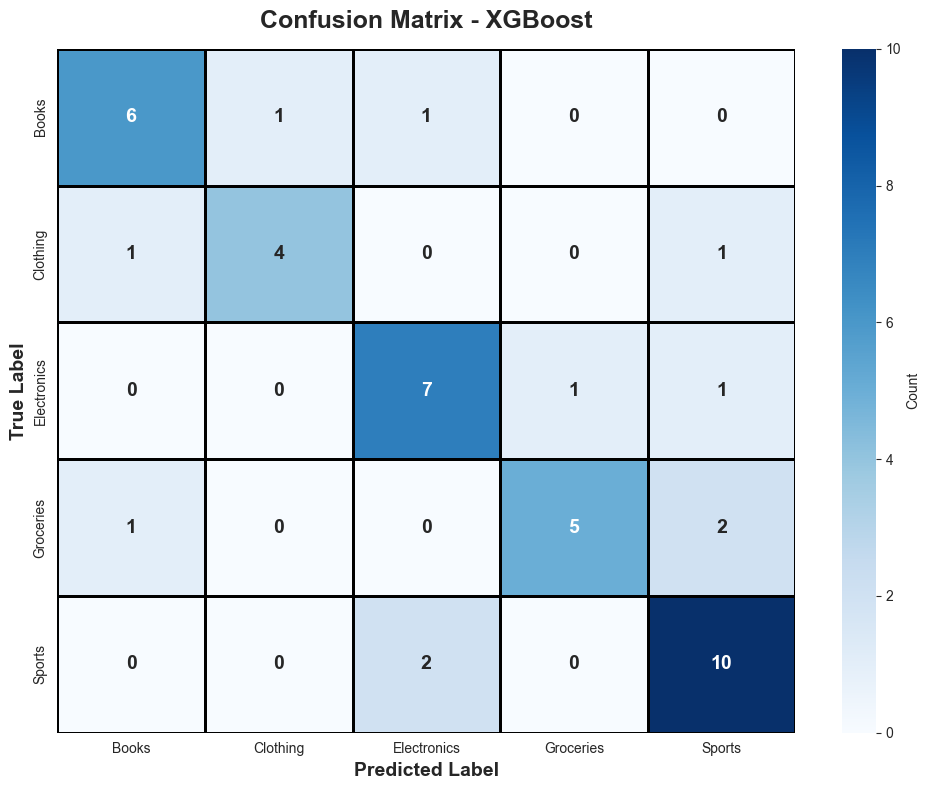

In [35]:
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='black',
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(visualizations_dir / 'Confusion_Matrix_Product_Model.png', dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved as '{visualizations_dir / 'Confusion_Matrix_Product_Model.png'}'\n ")
plt.show()

# Feature Importance

 Feature importance plot saved as 'c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook\product_recommendation_results\Visualizations\Feature_Importance_Product_Model.png'



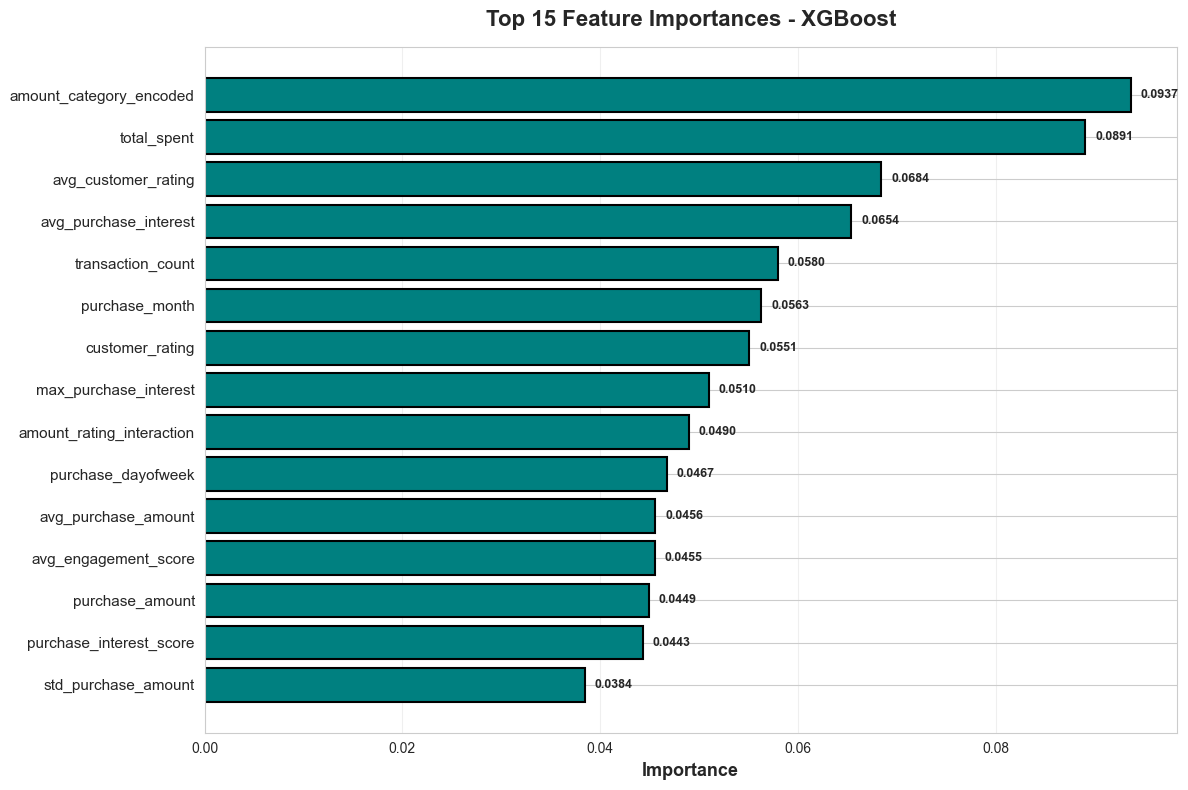

In [36]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(feature_importance)), feature_importance['importance'],
                    color='teal', edgecolor='black', linewidth=1.5)
    plt.yticks(range(len(feature_importance)), feature_importance['feature'], fontsize=11)
    plt.xlabel('Importance', fontsize=13, fontweight='bold')
    plt.title(f'Top 15 Feature Importances - {best_model_name}',
              fontsize=16, fontweight='bold', pad=15)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)

    for i, (bar, val) in enumerate(zip(bars, feature_importance['importance'])):
        plt.text(val + 0.001, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(visualizations_dir / 'Feature_Importance_Product_Model.png', dpi=300, bbox_inches='tight')
    print(f" Feature importance plot saved as '{visualizations_dir / 'Feature_Importance_Product_Model.png'}'\n")
    plt.show()
else:
    print(f"  {best_model_name} does not provide feature importances")

# Model Comparison Chart

 Model comparison chart saved as 'c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook\product_recommendation_results\Visualizations\Model_Comparison.png'



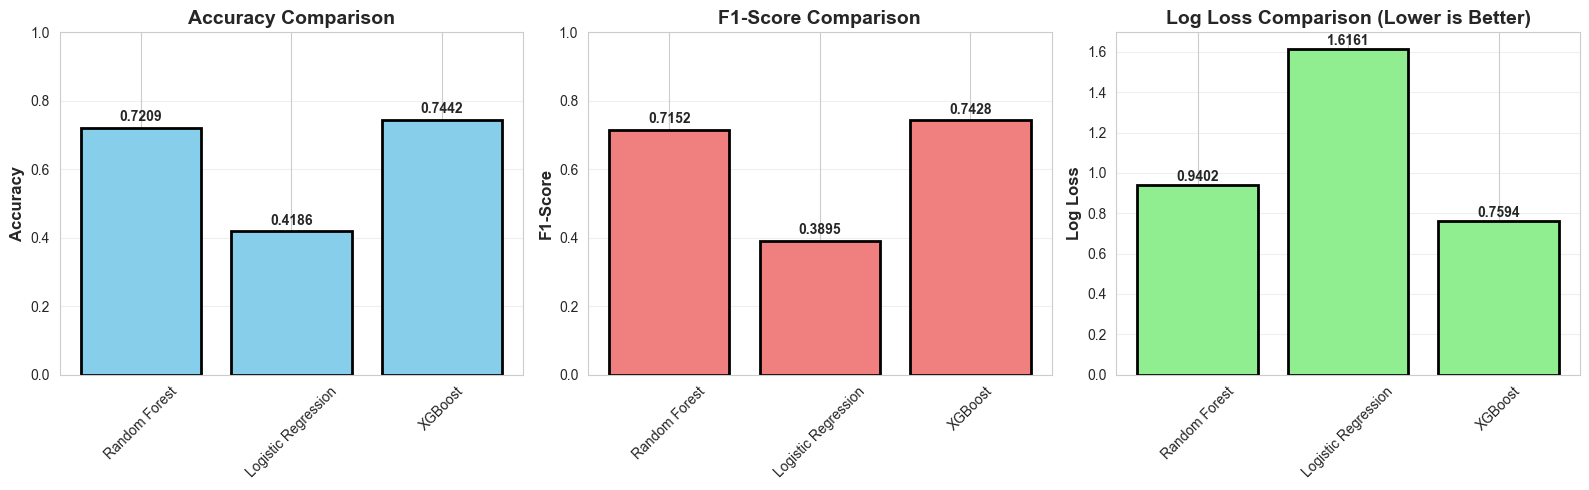

In [37]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'Log Loss': [results[m]['loss'] for m in results.keys()]
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'],
            color='skyblue', edgecolor='black', linewidth=2)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

axes[1].bar(comparison_df['Model'], comparison_df['F1-Score'],
            color='lightcoral', edgecolor='black', linewidth=2)
axes[1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

axes[2].bar(comparison_df['Model'], comparison_df['Log Loss'],
            color='lightgreen', edgecolor='black', linewidth=2)
axes[2].set_title('Log Loss Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Log Loss', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Log Loss']):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(visualizations_dir / 'Model_Comparison.png', dpi=300, bbox_inches='tight')
print(f" Model comparison chart saved as '{visualizations_dir / 'Model_Comparison.png'}'\n")
plt.show()

## Save the Model

In [38]:
# Set up paths (if not already set up in cell 2)
NOTEBOOK_DIR = Path.cwd()
results_dir = NOTEBOOK_DIR / "product_recommendation_results"
results_dir.mkdir(exist_ok=True)
visualizations_dir = results_dir / "Visualizations"
visualizations_dir.mkdir(exist_ok=True)

# Save model and preprocessing objects
joblib.dump(best_model, results_dir / "product_recommendation_model.pkl")
joblib.dump(scaler, results_dir / "product_recommendation_scaler.pkl")
joblib.dump(label_encoders, results_dir / "product_recommendation_label_encoders.pkl")

# Save feature importances if available
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    feature_importance.to_csv(results_dir / "product_recommendation_feature_importances.csv", index=False)

# Save performance metrics as JSON
performance_metrics = {
    'model_info': {
        'model_type': best_model_name,
        'best_model': best_model_name
    },
    'performance_metrics': {
        'accuracy': float(results[best_model_name]['accuracy']),
        'f1_score': float(results[best_model_name]['f1_score']),
        'log_loss': float(results[best_model_name]['loss'])
    },
    'all_models_performance': {
        model_name: {
            'accuracy': float(results[model_name]['accuracy']),
            'f1_score': float(results[model_name]['f1_score']),
            'log_loss': float(results[model_name]['loss'])
        }
        for model_name in results.keys()
    }
}

with open(results_dir / "product_recommendation_performance.json", 'w') as f:
    json.dump(performance_metrics, f, indent=4)

# Save additional files (optional - for reference)
df_fe.to_csv(results_dir / "engineered_customer_data.csv", index=False)

with open(results_dir / "model_features.txt", 'w') as f:
    f.write("PRODUCT RECOMMENDATION MODEL - FEATURES\n")
    f.write("="*70 + "\n\n")
    for i, feat in enumerate(feature_cols, 1):
        f.write(f"{i}. {feat}\n")

with open(results_dir / "model_performance_report.txt", 'w') as f:
    f.write("PRODUCT RECOMMENDATION MODEL - PERFORMANCE REPORT\n")
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Accuracy: {results[best_model_name]['accuracy']:.4f}\n")
    f.write(f"F1-Score: {results[best_model_name]['f1_score']:.4f}\n")
    f.write(f"Log Loss: {results[best_model_name]['loss']:.4f}\n\n")
    f.write("All Models Performance:\n")
    f.write("\n")
    for model_name in results.keys():
        f.write(f"\n{model_name}:\n")
        f.write(f"  Accuracy: {results[model_name]['accuracy']:.4f}\n")
        f.write(f"  F1-Score: {results[model_name]['f1_score']:.4f}\n")
        f.write(f"  Log Loss: {results[model_name]['loss']:.4f}\n")

print("\nModel and results saved successfully!")
print(f"Saved to: {results_dir}")
print(f"Visualizations saved to: {visualizations_dir}")
print("\nFiles saved:")
print("- product_recommendation_model.pkl (trained model)")
print("- product_recommendation_scaler.pkl (feature scaler)")
print("- product_recommendation_label_encoders.pkl (label encoders)")
if hasattr(best_model, 'feature_importances_'):
    print("- product_recommendation_feature_importances.csv")
print("- product_recommendation_performance.json (performance metrics)")
print("- engineered_customer_data.csv (processed data)")
print("- model_features.txt (feature list)")
print("- model_performance_report.txt (text report)")
print("\nVisualizations saved:")
print("- EDA_Product_Model.png")
print("- Confusion_Matrix_Product_Model.png")
print("- Feature_Importance_Product_Model.png")
print("- Model_Comparison.png")
print("\n PRODUCT RECOMMENDATION MODEL COMPLETED!")


Model and results saved successfully!
Saved to: c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook\product_recommendation_results
Visualizations saved to: c:\Users\LENOVO\Desktop\Formative-2__Data-Preprocessing\model_notebook\product_recommendation_results\Visualizations

Files saved:
- product_recommendation_model.pkl (trained model)
- product_recommendation_scaler.pkl (feature scaler)
- product_recommendation_label_encoders.pkl (label encoders)
- product_recommendation_feature_importances.csv
- product_recommendation_performance.json (performance metrics)
- engineered_customer_data.csv (processed data)
- model_features.txt (feature list)
- model_performance_report.txt (text report)

Visualizations saved:
- EDA_Product_Model.png
- Confusion_Matrix_Product_Model.png
- Feature_Importance_Product_Model.png
- Model_Comparison.png

 PRODUCT RECOMMENDATION MODEL COMPLETED!
